In [7]:
%matplotlib inline

from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns

sns.set(color_codes=True)

In [8]:
pcap = rdpcap('wireshark.pcap')
pcap

<wireshark.pcap: TCP:495 UDP:36 ICMP:28 Other:8>

In [10]:
#Retrieving a single item from the packet list
ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload

print("ethernet_frame : ", ethernet_frame.show(), "\n\n")
print("ip_packet : ", ip_packet.show(), "\n\n")
print("segment : ", segment.show() ,"\n\n")
print("data : ", data.show() ,"\n\n") # If blank, empty object

###[ Ethernet ]### 
  dst       = 01:00:5e:00:00:fb
  src       = ea:7f:95:6b:2c:64
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 236
     id        = 3170
     flags     = 
     frag      = 0
     ttl       = 255
     proto     = udp
     chksum    = 0x178e
     src       = 172.20.10.1
     dst       = 224.0.0.251
     \options   \
###[ UDP ]### 
        sport     = mdns
        dport     = mdns
        len       = 216
        chksum    = 0x39d
###[ DNS ]### 
           id        = 0
           qr        = 1
           opcode    = QUERY
           aa        = 1
           tc        = 0
           rd        = 0
           ra        = 0
           z         = 0
           ad        = 0
           cd        = 0
           rcode     = ok
           qdcount   = 0
           ancount   = 4
           nscount   = 0
           arcount   = 0
           qd        = None
           \an        \
            |###[ DNS Resource Record ]#

In [15]:
#Collect the field names from IP/TCP/UDP (These will be the columns in the DataFrame)

ip_fields =[field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

# print("ip_fields : ", ip_fields)
# print("tcp_fields : ", tcp_fields)
# print("udp_fields : ", udp_fields)

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']

print("Dataframe_fields : ", dataframe_fields)

# Create a blank DataFrame.
df = pd.DataFrame(columns = dataframe_fields)

for packet in pcap[IP]:
    #Field array for each row of DataFrame
    field_values = []
    # Add all field values
    for field in ip_fields:
        if field == 'options':
            # Retrieving the number of options defined in IP headers
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
            #print(packet[IP].fields[field]) 
            
    field_values.append(packet.time)
    #print("Packet Time : ", packet.time) 
    
    layer_type = type(packet[IP].payload)
    #print("Layer Type : ", layer_type)   
    
    
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
            
    # Append payload
    field_values.append(len(packet[layer_type].payload))
    
    field_values.append(packet[layer_type].payload.original)
    #print("packet[layer_type].payload.original : ",  packet[layer_type].payload.original)
    
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    #print("binascii.hexlify(packet[layer_type].payload.original) : ", binascii.hexlify(packet[layer_type].payload.original))
    
    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")
        
        

Dataframe_fields :  ['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto', 'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq', 'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr', 'options', 'payload', 'payload_raw', 'payload_hex']


In [16]:
# Retrieve first row from DataFrame
print(df.iloc[0])

version                                                        4
ihl                                                            5
tos                                                            0
len                                                          236
id                                                          3170
flags                                                           
frag                                                           0
ttl                                                          255
proto                                                         17
chksum                                                      6030
src                                                  172.20.10.1
dst                                                  224.0.0.251
options                                                        0
time                                           1651735048.090154
sport                                                       5353
dport                    

In [17]:
# Shape of the dataframe
print("The shape of the dataframe is : ", df.shape)

The shape of the dataframe is :  (78, 28)


In [18]:
# Return first 5 rows
df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,236,3170,,0,255,17,6030,...,None,None,None,None,925,None,None,208,b'\x00\x00\x84\x00\x00\x00\x00\x04\x00\x00\x00...,b'000084000000000400000000075f72646c696e6b045f...
1,4,5,0,339,62048,,0,255,17,12584,...,None,None,None,None,20356,None,None,311,b'\x00\x00\x84\x00\x00\x00\x00\x03\x00\x00\x00...,b'00008400000000030000000401310231300232300331...
2,4,5,0,138,56588,,0,255,17,18245,...,None,None,None,None,49469,None,None,110,b'\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00...,b'000000000003000000000001026c62075f646e732d73...
3,4,5,0,416,37236,,0,255,17,48297,...,None,None,None,None,38356,None,None,388,b'\x00\x00\x84\x00\x00\x00\x00\x01\x00\x00\x00...,b'0000840000000001000000060f5f636f6d70616e696f...
4,4,5,0,302,20810,,0,255,17,53859,...,None,None,None,None,55184,None,None,274,b'\x00\x00\x00\x00\x00\x03\x00\x00\x00\x05\x00...,b'0000000000030000000500010c76616e736f6e6c7976...


In [19]:
# Return last 5 rows
df.tail()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
73,4,5,0,64,36259,,0,63,6,26039,...,11,0,A,501,62170,0,6,0,b'',b''
74,4,5,0,84,1910,,0,64,1,1797,...,None,None,None,None,60804,None,None,56,b'bsz\x1a\x00\x04\x1e\xd8\x08\t\n\x0b\x0c\r\x0...,b'62737a1a00041ed808090a0b0c0d0e0f101112131415...
75,4,5,0,84,21597,,0,64,1,47645,...,None,None,None,None,62852,None,None,56,b'bsz\x1a\x00\x04\x1e\xd8\x08\t\n\x0b\x0c\r\x0...,b'62737a1a00041ed808090a0b0c0d0e0f101112131415...
76,4,5,0,84,8257,,0,64,1,60985,...,None,None,None,None,59130,None,None,56,b'bsz\x1b\x00\x04%`\x08\t\n\x0b\x0c\r\x0e\x0f\...,b'62737a1b0004256008090a0b0c0d0e0f101112131415...
77,4,5,0,84,2805,,0,64,1,902,...,None,None,None,None,61178,None,None,56,b'bsz\x1b\x00\x04%`\x08\t\n\x0b\x0c\r\x0e\x0f\...,b'62737a1b0004256008090a0b0c0d0e0f101112131415...


In [20]:
df.to_csv("wireshark.csv")

In [21]:
# Top Source Adddress
print("[*] Top Source Address: \n", df['src'].describe(), "\n\n")

# Top Destination Address
print("[*] Top Destination Address: \n ", df['dst'].describe(), "\n\n")

frequent_address = df['src'].describe()['top']
print("Frequent Address : ", frequent_address, "\n\n")

# Who is the top address speaking to
print("[*] Who is Top Address Speaking to?: \n ", df[df['src'] == frequent_address]['dst'].unique(), "\n\n")

# Who is the top address speaking to (dst ports)
print("[*] Who is the top address speaking to (Destination Ports): \n ", df[df['src'] == frequent_address]['dport'].unique(), "\n\n")

[*] Top Source Address: 
 count              78
unique              4
top       172.20.10.5
freq               34
Name: src, dtype: object 


[*] Top Destination Address: 
  count              78
unique              5
top       172.20.10.5
freq               31
Name: dst, dtype: object 


Frequent Address :  172.20.10.5 


[*] Who is Top Address Speaking to?: 
  ['172.20.10.1' '224.0.0.251' '34.237.73.95' '142.250.67.74'] 


[*] Who is the top address speaking to (Destination Ports): 
  [5353 62078 None 443] 




<AxesSubplot:title={'center':'Addresses Sending Payloads'}, ylabel='src'>

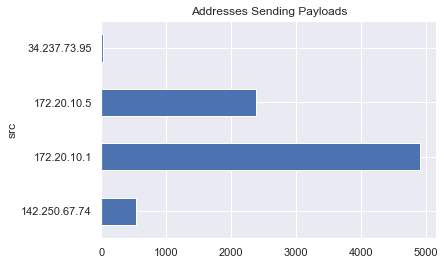

In [22]:
# Group by Source Address and Payload Sum
source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads")

<AxesSubplot:title={'center':'Destination Addresses (Bytes Received)'}, ylabel='dst'>

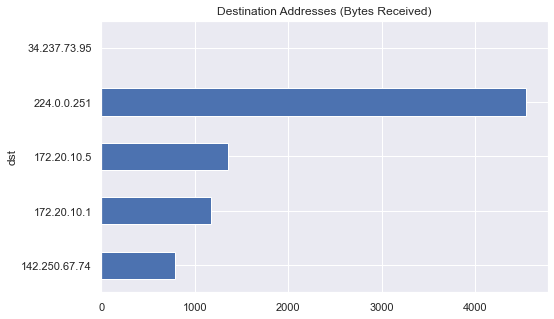

In [23]:
# Group by Destination Address and Payload Sum
destination_addresses = df.groupby("dst")['payload'].sum()
destination_addresses.plot(kind='barh', title="Destination Addresses (Bytes Received)",figsize=(8,5))

<AxesSubplot:title={'center':'Source Ports (Bytes Sent)'}, ylabel='sport'>

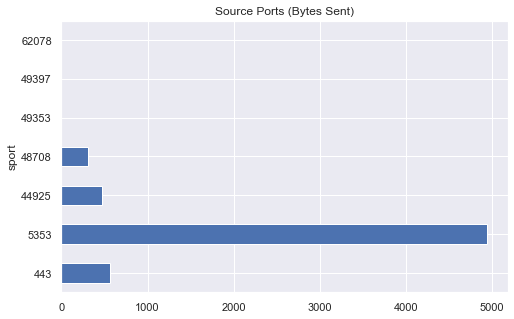

In [24]:
# Group by Source Port and Payload Sum
source_payloads = df.groupby("sport")['payload'].sum()
source_payloads.plot(kind='barh',title="Source Ports (Bytes Sent)",figsize=(8,5))

<AxesSubplot:title={'center':'Destination Ports (Bytes Received)'}, ylabel='dport'>

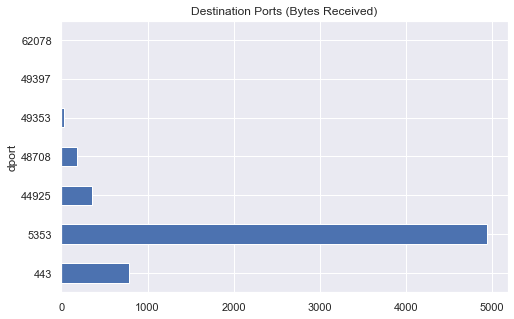

In [25]:
# Group by Destination Port and Payload Sum
destination_payloads = df.groupby("dport")['payload'].sum()
destination_payloads.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

172.20.10.1 May be an interesting address
[b'\x00\x00\x84\x00\x00\x00\x00\x01\x00\x00\x00\x06\x0f_companion-link\x04_tcp\x05local\x00\x00\x0c\x00\x01\x00\x00\x11\x94\x00\x1b\x18Vanshika\xe2\x80\x99s MacBook Air\xc0\x0c\xc02\x00!\x80\x01\x00\x00\x00x\x00\x1e\x00\x00\x00\x00\xc0\x0f\x15Vanshikas-MacBook-Air\xc0!\xc02\x00\x10\x80\x01\x00\x00\x11\x94\x00^\x16rpBA=0F:5D:B5:C8:C8:CE\x11rpAD=e51e6b6633e9\x0crpFl=0x20040\x11rpHN=446e3f9a4d59\x07rpMac=0\rrpVr=340.19.1\x18Vanshika\xe2\x80\x99s MacBook Air\x0c_device-info\xc0\x1c\x00\x10\x00\x01\x00\x00\x11\x94\x00)\x14model=MacBookAir10,1\nosxvers=21\x08icolor=3\xc0_\x00\x1c\x80\x01\x00\x00\x00x\x00\x10\xfe\x80\x00\x00\x00\x00\x00\x00\x10<\xa0\xe2\xe9b\x0cc\xc0_\x00\x01\x80\x01\x00\x00\x00x\x00\x04\xac\x14\n\x05\xc0_\x00\x1c\x80\x01\x00\x00\x00x\x00\x10$\x01I\x003\xb5\x0c\x93\x0c\xa1\x84b\x83\xa5\xb0\xee', b'', b'', b'bsz\x0e\x00\x03zE\x08\t\n\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f !"#$%&\'()*+,-./01234

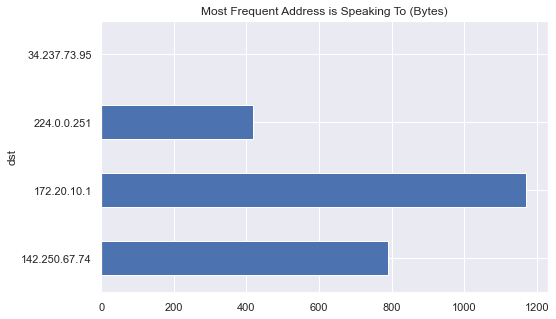

In [26]:
# Create dataframe with only converation from most frequent address
frequent_address_df = df[df['src']==frequent_address]

# Only display Src Address, Dst Address, and group by Payload 
frequent_address_groupby = frequent_address_df[['src','dst','payload']].groupby("dst")['payload'].sum()

# Plot the Frequent address is speaking to (By Payload)
frequent_address_groupby.plot(kind='barh',title="Most Frequent Address is Speaking To (Bytes)",figsize=(8,5))

# Which address has excahnged the most amount of bytes with most frequent address
ip_of_interest = frequent_address_groupby.sort_values(ascending=False).index[0]
print(ip_of_interest, "May be an interesting address")

# Create dataframe with only conversation from most frequent address and suspicious address
ip_of_interest_df = frequent_address_df[frequent_address_df['dst']==ip_of_interest]

# Store each payload in an array
raw_stream = []
for p in ip_of_interest_df['payload_raw']:
    raw_stream.append(p)
    
print(raw_stream)